In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests

from strong_wind_warning_app.config import get_settings

In [2]:
s = get_settings()

# OpenWeather API

Example OpenWeather output:                      
```
                

{
  "lat": 33.44,
  "lon": -94.04,
  "timezone": "America/Chicago",
  "timezone_offset": -21600,
  "current": {
    "dt": 1618317040,
    "sunrise": 1618282134,
    "sunset": 1618333901,
    "temp": 284.07,
    "feels_like": 282.84,
    "pressure": 1019,
    "humidity": 62,
    "dew_point": 277.08,
    "uvi": 0.89,
    "clouds": 0,
    "visibility": 10000,
    "wind_speed": 6,
    "wind_deg": 300,
    "weather": [
      {
        "id": 500,
        "main": "Rain",
        "description": "light rain",
        "icon": "10d"
      }
    ],
    "rain": {
      "1h": 0.21
    }
  },
    "minutely": [
    {
      "dt": 1618317060,
      "precipitation": 0.205
    },
    ...
  },
    "hourly": [
    {
      "dt": 1618315200,
      "temp": 282.58,
      "feels_like": 280.4,
      "pressure": 1019,
      "humidity": 68,
      "dew_point": 276.98,
      "uvi": 1.4,
      "clouds": 19,
      "visibility": 306,
      "wind_speed": 4.12,
      "wind_deg": 296,
      "wind_gust": 7.33,
      "weather": [
        {
          "id": 801,
          "main": "Clouds",
          "description": "few clouds",
          "icon": "02d"
        }
      ],
      "pop": 0
    },
    ...
  }
    "daily": [
    {
      "dt": 1618308000,
      "sunrise": 1618282134,
      "sunset": 1618333901,
      "moonrise": 1618284960,
      "moonset": 1618339740,
      "moon_phase": 0.04,
      "temp": {
        "day": 279.79,
        "min": 275.09,
        "max": 284.07,
        "night": 275.09,
        "eve": 279.21,
        "morn": 278.49
      },
      "feels_like": {
        "day": 277.59,
        "night": 276.27,
        "eve": 276.49,
        "morn": 276.27
      },
      "pressure": 1020,
      "humidity": 81,
      "dew_point": 276.77,
      "wind_speed": 3.06,
      "wind_deg": 294,
      "weather": [
        {
          "id": 500,
          "main": "Rain",
          "description": "light rain",
          "icon": "10d"
        }
      ],
      "clouds": 56,
      "pop": 0.2,
      "rain": 0.62,
      "uvi": 1.93
    },
    ...
    },
    "alerts": [
    {
      "sender_name": "NWS Tulsa",
      "event": "Heat Advisory",
      "start": 1597341600,
      "end": 1597366800,
      "description": "...HEAT ADVISORY REMAINS IN EFFECT FROM 1 PM THIS AFTERNOON TO\n8 PM CDT THIS EVENING...\n* WHAT...Heat index values of 105 to 109 degrees expected.\n* WHERE...Creek, Okfuskee, Okmulgee, McIntosh, Pittsburg,\nLatimer, Pushmataha, and Choctaw Counties.\n* WHEN...From 1 PM to 8 PM CDT Thursday.\n* IMPACTS...The combination of hot temperatures and high\nhumidity will combine to create a dangerous situation in which\nheat illnesses are possible.",
      "tags": [
        "Extreme temperature value"
        ]
    },
    ...
  ]
}
```

## Current Weather Data

### Get current wind:

In [3]:
def get_current_wind_forecast() -> dict:
    current_exclusions = ",".join([
        i for i in s.OPEN_WEATHER_API_TYPES if i != "current"
    ])
    wind_fields = ["wind_speed", "wind_deg", "wind_gust"]

    request_url = (
        f"{s.OPEN_WEATHER_URL_BASE}"
        f"?lat={s.LOCATION_LATITUDE}&lon={s.LOCATION_LONGITUDE}"
        f"&exclude=[{current_exclusions}]"
        f"&appid={s.OPEN_WEATHER_API_KEY}"
    )

    output = requests.get(request_url)

    if output.status_code == 200:
        output_json = json.loads(output.text)
        wind = {
            k: v for k, v in output_json["current"].items() if k in wind_fields
        }

        return wind

In [4]:
# Note: Wind speed is expressed in metres/second
get_current_wind_forecast()

{'wind_speed': 0.45, 'wind_deg': 168, 'wind_gust': 0.89}

## Hourly Forecasts

In [27]:
def get_hourly_forecasts() -> dict:
    current_exclusions = ",".join([
        i for i in s.OPEN_WEATHER_API_TYPES if i != "hourly"
    ])
    output_fields = ["dt", "wind_speed", "wind_deg", "wind_gust"]

    request_url = (
        f"{s.OPEN_WEATHER_URL_BASE}"
        f"?lat={s.LOCATION_LATITUDE}&lon={s.LOCATION_LONGITUDE}"
        f"&exclude=[{current_exclusions}]"
        f"&appid={s.OPEN_WEATHER_API_KEY}"
    )

    output = requests.get(request_url)

    if output.status_code == 200:
        output_json = json.loads(output.text)
        hourly_forecasts = output_json["hourly"]

        hourly_forecast_records = [
            [hfc[wf] for wf in output_fields] for hfc in hourly_forecasts
        ]

        output_df = pd.DataFrame(
            data=hourly_forecast_records,
            columns=output_fields,
        )

        output_df["dt"] = pd.to_datetime(output_df['dt'],unit='s')
        output_df.set_index("dt", inplace=True)

        return output_df

In [28]:
hourly_forecasts = get_hourly_forecasts()

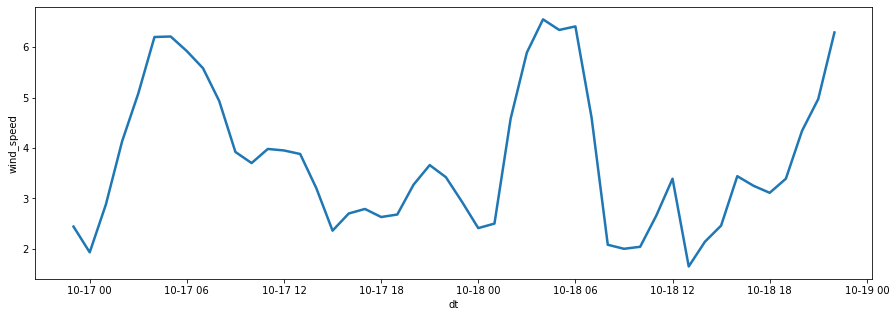

In [29]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=hourly_forecasts["wind_speed"], palette="tab10", linewidth=2.5)
plt.show()

In [66]:
above_threshold = []

for dt, ws in hourly_forecasts[["wind_speed"]].itertuples():
    if ws >= 5.5: # Arbitrary at this stage
        above_threshold.append(dt)
    else:
        above_threshold.append("-")

In [73]:
above_threshold[6] = '-'
above_threshold

['-',
 '-',
 '-',
 '-',
 '-',
 Timestamp('2021-10-17 04:00:00'),
 '-',
 Timestamp('2021-10-17 06:00:00'),
 Timestamp('2021-10-17 07:00:00'),
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 Timestamp('2021-10-18 03:00:00'),
 Timestamp('2021-10-18 04:00:00'),
 Timestamp('2021-10-18 05:00:00'),
 Timestamp('2021-10-18 06:00:00'),
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 Timestamp('2021-10-18 22:00:00')]

In [79]:
atp = ['-'] + above_threshold + ['-']

sliding_windows = list(zip(atp[:-2], atp[1:-1], atp[2:]))

skip_single_dips = [
    j for i, j, k in sliding_windows
    if not (
        (i != '-') and (j == '-') and (k != '-')
    )
]

In [80]:
skip_single_dips

['-',
 '-',
 '-',
 '-',
 '-',
 Timestamp('2021-10-17 04:00:00'),
 Timestamp('2021-10-17 06:00:00'),
 Timestamp('2021-10-17 07:00:00'),
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 Timestamp('2021-10-18 03:00:00'),
 Timestamp('2021-10-18 04:00:00'),
 Timestamp('2021-10-18 05:00:00'),
 Timestamp('2021-10-18 06:00:00'),
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 Timestamp('2021-10-18 22:00:00')]

In [92]:
first_ts = False

if set(skip_single_dips) != {'-'}:
    for i, item in enumerate(skip_single_dips):
        if item == "-" and not first_ts:
            pass
        elif item != "-" and not first_ts:
            first_index = i
            first_ts = True
        elif item != "-" and first_ts:
            pass
        elif item == "-" and first_ts:
            last_index = i-1
            break


In [ ]:
### STOPPED HERE ###

In [93]:
print(first_index, last_index)

5 7


In [45]:
min_ = min(mins)
min_

Timestamp('2021-10-17 02:00:00')

In [41]:
maxes

[Timestamp('2021-10-17 06:00:00'),
 Timestamp('2021-10-17 07:00:00'),
 Timestamp('2021-10-17 08:00:00'),
 Timestamp('2021-10-17 09:00:00'),
 Timestamp('2021-10-18 05:00:00'),
 Timestamp('2021-10-18 06:00:00'),
 Timestamp('2021-10-18 07:00:00'),
 Timestamp('2021-10-18 08:00:00'),
 Timestamp('2021-10-19 00:00:00')]

In [44]:
max_ = max(maxes)
max_

Timestamp('2021-10-19 00:00:00')

In [46]:
warning_range = (min_, max_)

# Simulate Session Times

In [57]:
import random
from datetime import datetime
df = pd.DataFrame()
df["dt"] = pd.date_range(
    datetime.now().replace(second=0, microsecond=0),
    periods = 2760,
    freq='min'
)
df["class_type"] = random.choices(['A', 'B', 'C', 'D', 'E'], k=2760)
df["user_alerted"] = False

df = df.sample(100)

df

,dt,class_type,user_alerted
827,2021-10-18 05:47:00,B,False
1267,2021-10-18 13:07:00,B,False
1295,2021-10-18 13:35:00,B,False
1905,2021-10-18 23:45:00,C,False
1683,2021-10-18 20:03:00,D,False
...,...,...,...
1142,2021-10-18 11:02:00,C,False
2298,2021-10-19 06:18:00,C,False
425,2021-10-17 23:05:00,B,False
868,2021-10-18 06:28:00,B,False


# Find Alert Window

Timestamp('2021-10-18 11:02:00')

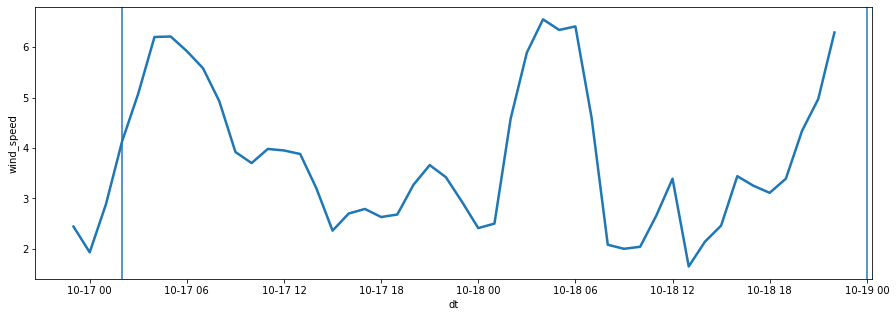

In [62]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=hourly_forecasts["wind_speed"], palette="tab10", linewidth=2.5)
plt.axvline(min_)
plt.axvline(max_)
plt.show()